In [35]:
import pandas as pd
import torch
import torch.nn as nn
import os
import opendatasets as od
import matplotlib.pyplot as plt
import numpy as np
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from keras.utils import to_categorical
from gensim.models import Word2Vec

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /Users/adlfkl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adlfkl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/adlfkl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/adlfkl/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/adlfkl/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

# **About Dataset**

## **Twitter Sentiment Analysis Dataset**

### **Overview**

This is an entity-level sentiment analysis dataset of twitter. Given a message and an entity, the task is to judge the sentiment of the message about the entity. There are three classes in this dataset: Positive, Negative and Neutral. We regard messages that are not relevant to the entity (i.e. Irrelevant) as Neutral.

### **Usage**

Please use twitter_training.csv as the training set and twitter_validation.csv as the validation set. Top 1 classification 
accuracy is used as the metric.

[Link to dataset](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/)

# 1. Loading Dataset

In [36]:
#Creating data folder
try:
    os.mkdir('data')
except FileExistsError:
    print("Data folder already exits. Reading data... ")

#Reading data if it exists, or downloading it if it doesn't.   
data_training_original = None
data_validation_original = None   
data_path = os.path.join('data/twitter-entity-sentiment-analysis')
training_path  = os.path.join('data','twitter-entity-sentiment-analysis','twitter_training.csv')
valid_path = path  = os.path.join('data','twitter-entity-sentiment-analysis','twitter_validation.csv')

if not os.path.isdir(data_path):
    print("Data folder not found. Downloading...")
    od.download('https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/download?datasetVersionNumber=2','data')
    print("Data downloaded. Reading data...")
data_training_original = pd.read_csv(training_path)
data_validation_original = pd.read_csv(valid_path)
data_training = data_training_original.copy()
data_validation = data_validation_original.copy()

print("Data read sucessfully!\n Training data head:")
data_training.head()

Data folder already exits. Reading data... 
Data read sucessfully!
 Training data head:


,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


# 2. Exploratory Data Analysis

In [37]:
#Adding headers to data
data_training.columns = ['tweet_id', 'entity', 'sentiment', 'tweet_content']
data_validation.columns = ['tweet_id', 'entity', 'sentiment', 'tweet_content']
data_validation.head()

,tweet_id,entity,sentiment,tweet_content
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [38]:
#Checking shape of datasets
print(data_training.shape)
print(data_validation.shape)

(74681, 4)
(999, 4)


In [39]:
#Checking counts of tweet id's in the training dataset
print(data_training['tweet_id'].value_counts())
print("\n",data_training['tweet_id'].value_counts().value_counts())

5203    6
6164    6
6141    6
6142    6
6143    6
       ..
4678    6
4679    6
4680    6
4681    6
2401    5
Name: tweet_id, Length: 12447, dtype: int64

 6    12446
5        1
Name: tweet_id, dtype: int64


In [40]:
#Checking counts of sentiment categories in the training dataset.
print('Sentiment couns in training dataset\n',data_training['sentiment'].value_counts())
print('\nSentiment couns in validation dataset\n',data_validation['sentiment'].value_counts())


Sentiment couns in training dataset
 Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: sentiment, dtype: int64

Sentiment couns in validation dataset
 Neutral       285
Positive      277
Negative      266
Irrelevant    171
Name: sentiment, dtype: int64


In [41]:
#Checking counts of entities in the training dataset - all of them are represented almost equally.
print(data_training['entity'].value_counts())
print("\nMaximum difference between entities representation: ",max(data_training['entity'].value_counts())-min(data_training['entity'].value_counts()))
print("Number of entities: ",data_training['entity'].nunique())
print("Number of entities after lowering case: ",data_training['entity'].apply(str.lower).nunique())

TomClancysRainbowSix                 2400
MaddenNFL                            2400
Microsoft                            2400
LeagueOfLegends                      2394
CallOfDuty                           2394
Verizon                              2382
CallOfDutyBlackopsColdWar            2376
ApexLegends                          2376
Facebook                             2370
WorldOfCraft                         2364
Dota2                                2364
NBA2K                                2352
TomClancysGhostRecon                 2346
Battlefield                          2346
FIFA                                 2340
Xbox(Xseries)                        2334
Overwatch                            2334
johnson&johnson                      2328
Amazon                               2316
PlayStation5(PS5)                    2310
HomeDepot                            2310
Cyberpunk2077                        2304
CS-GO                                2304
GrandTheftAuto(GTA)               

In [42]:
print("Missing values in training data:\n",data_training.isnull().sum())
print("\n Missing values in validation data:\n",data_validation.isnull().sum())

Missing values in training data:
 tweet_id           0
entity             0
sentiment          0
tweet_content    686
dtype: int64

 Missing values in validation data:
 tweet_id         0
entity           0
sentiment        0
tweet_content    0
dtype: int64


# Data Preprocessing

After exploratory data analysis the following steps will be made to clean the data:
1. Removing rows with missing data. Less than 1% rows contain missing data, so there's no need to impute.
2. Removing rows with sentiment marked as 'Irrelevant'
3. Removing non-alphanumeric characters from tweet_content column
4. Lowering case of all words in tweet_content column
5. Removing white spaces from tweet_content column
6. Lemantization of tweet_content column
7. Codifying entity, and tweet_content column in UTF-8.
8. Tokenization of tweet_content column
9. Handling Irrelevant category in sentiment column

In [43]:
#1. Removing missing data
data_training = data_training.dropna()
print("Missing values in training data:\n",data_training.isnull().sum(),"\n Training data size: ", data_training.shape)

Missing values in training data:
 tweet_id         0
entity           0
sentiment        0
tweet_content    0
dtype: int64 
 Training data size:  (73995, 4)


In [44]:
data_training = data_training[data_training['sentiment'] != 'Irrelevant']
print(data_training['sentiment'].value_counts())

data_validation = data_validation[data_validation['sentiment'] != 'Irrelevant']
print(data_validation['sentiment'].value_counts())

Negative    22358
Positive    20654
Neutral     18108
Name: sentiment, dtype: int64
Neutral     285
Positive    277
Negative    266
Name: sentiment, dtype: int64


In [45]:
# Merging Entity and Tweet into a single feature. 
data_training['tweet_content'] = data_training['entity'].astype(str) + " " + data_training['tweet_content'].astype(str)
data_training.drop(['entity','tweet_id'], axis='columns')
data_validation['tweet_content'] = data_validation['entity'].astype(str) + " " + data_validation['tweet_content'].astype(str)
data_validation.drop(['entity','tweet_id'], axis='columns')

,sentiment,tweet_content
0,Neutral,Amazon BBC News - Amazon boss Jeff Bezos rejec...
1,Negative,Microsoft @Microsoft Why do I pay for WORD whe...
2,Negative,CS-GO CSGO matchmaking is so full of closet ha...
3,Neutral,Google Now the President is slapping Americans...
4,Negative,FIFA Hi @EAHelp I’ve had Madeleine McCann in m...
...,...,...
992,Negative,Amazon Please explain how this is possible! Ho...
993,Positive,PlayStation5(PS5) Good on Sony. As much as I w...
996,Positive,Borderlands Today sucked so it’s time to drink...
997,Positive,Microsoft Bought a fraction of Microsoft today...


In [46]:
#2. Defining functions to perform data transofrmations mentioned in points 2-7
def remove_stop_words(tokens):
    return [word for word in tokens if word not in stopwords.words('english')]

def lower_case(tokens):
    return [str.lower(word) for word in tokens]

def remove_nonalpha(tokens):
    return [word for word in tokens if word.isalpha()]

def to_lemmatizer_tags(tagged_tokens):
    out = []
    for token, tag in tagged_tokens:
        if tag == 'ADJ':
            out.append((token,wordnet.ADJ))
        elif tag == 'VERB':
            out.append((token,wordnet.VERB))
        elif tag == 'NOUN':
            out.append((token,wordnet.NOUN))
        elif tag == 'ADV':
            out.append((token,wordnet.ADV))
        else:
            # Here I append noun, as it is the default tag in WordTokenizer
            out.append((token,wordnet.NOUN))
    return out

def lemmatize_tokens(tagged_tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token,tag) for token, tag in tagged_tokens]
    
def process_tweet(tweet):
    tokens = word_tokenize(tweet)
    tokens = [emoji.demojize(token) if emoji.is_emoji(token) else token for token in tokens]
    tagged_tokens = nltk.pos_tag(tokens,tagset='universal')
    tagged_tokens = to_lemmatizer_tags(tagged_tokens)
    tokens = lemmatize_tokens(tagged_tokens)
    tokens = lower_case(tokens)
    tokens = remove_stop_words(tokens)
    tokens = remove_nonalpha(tokens)
    return tokens

In [47]:
#Creating new columns with processed tweet contents. (For me it takes around 3 minutes)
data_training['processed_tweet'] = data_training['tweet_content'].apply(process_tweet)
data_validation['processed_tweet'] = data_validation['tweet_content'].apply(process_tweet)

In [48]:
data_training.head()

,tweet_id,entity,sentiment,tweet_content,processed_tweet
0,2401,Borderlands,Positive,Borderlands I am coming to the borders and I w...,"[borderlands, come, border, kill]"
1,2401,Borderlands,Positive,Borderlands im getting on borderlands and i wi...,"[borderlands, im, get, borderland, kill]"
2,2401,Borderlands,Positive,Borderlands im coming on borderlands and i wil...,"[borderlands, im, come, borderland, murder]"
3,2401,Borderlands,Positive,Borderlands im getting on borderlands 2 and i ...,"[borderlands, im, get, borderland, murder]"
4,2401,Borderlands,Positive,Borderlands im getting into borderlands and i ...,"[borderlands, im, get, borderland, murder]"


In [49]:
#Checking for duplicated processed tweets
print(f'There are {int(data_training["processed_tweet"].duplicated().sum())} duplicated tweets in training set, and {int(data_validation["processed_tweet"].duplicated().sum())} duplicated tweets in the validation set. They will be removed now')
data_training.drop_duplicates('processed_tweet',inplace=True)
data_validation.drop_duplicates('processed_tweet',inplace=True)
print("Duplicates deleted!")

There are 11056 duplicated tweets in training set, and 3 duplicated tweets in the validation set. They will be removed now
Duplicates deleted!


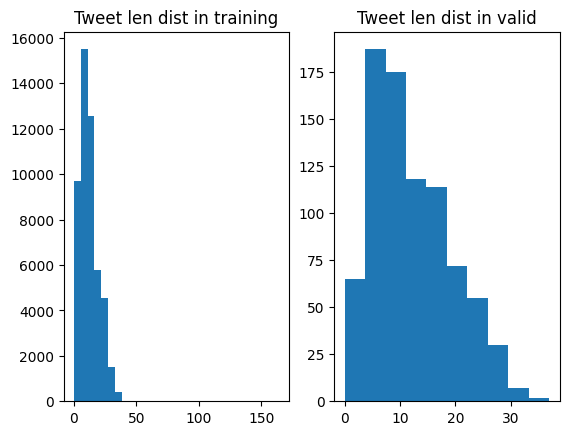

Training Q1: 6.0, Q3: 16.0, IQR: 15.0
Validation Q1: 7.0, Q3: 17.0, IQR: 15.0


In [50]:
#Checking the distribution of tweets length. Most of the tweets seems to be of length below 32
fig, ax = plt.subplots(1,2)
ax[0].hist(data_training['processed_tweet'].apply(len),bins=30)
ax[0].set_title("Tweet len dist in training")
ax[1].hist(data_validation['processed_tweet'].apply(len))
ax[1].set_title("Tweet len dist in valid")
plt.show()

q1 = np.quantile(data_training['processed_tweet'].apply(len),q=0.25)
q3 = np.quantile(data_training['processed_tweet'].apply(len),q=0.75)
iqr = 1.5*(q3-q1)
print(f"Training Q1: {q1}, Q3: {q3}, IQR: {iqr}")

q1_valid = np.quantile(data_validation['processed_tweet'].apply(len),q=0.25)
q3_valid = np.quantile(data_validation['processed_tweet'].apply(len),q=0.75)
iqr_valid = 1.5*(q3_valid-q1_valid)

print(f"Validation Q1: {q1_valid}, Q3: {q3_valid}, IQR: {iqr_valid}")

In [51]:
#Removing tweets exceeding IQR Rule. Training IQR was used for both datasets, since id did not make a difference in case of validation set.
 
train_drop = len(data_training) - len(data_training[data_training['processed_tweet'].apply(len) <= q3+iqr])
valid_drop = len(data_validation) - len(data_validation[data_validation['processed_tweet'].apply(len) <= q3+iqr])
print(f"{train_drop} rows are removed from training, and {valid_drop} from validation sets due too tweet length IQR rule")

data_training = data_training[data_training['processed_tweet'].apply(len) <= q3+iqr]
data_validation = data_validation[data_validation['processed_tweet'].apply(len) <= q3+iqr]

640 rows are removed from training, and 2 from validation sets due too tweet length IQR rule


# Data Encoding
In this part data will be encoded, so a neural network can be fed with it.

In [52]:
#Tokenizing tweets to Integers based in their frequency among all words used in the database.

# Obtaining all words used in all tweets
all_words = []
data_training['processed_tweet'].apply(lambda x: all_words.append(x))
data_validation['processed_tweet'].apply(lambda x: all_words.append(x))
all_words = [x for y in all_words for x in y]

#Creating a word-to-int dictionary based in frequency of each word
count_words = Counter(all_words).most_common()
print("5 most common words: ",count_words[:5])
vocab_to_int = {w: i+1 for i,(w,c) in enumerate(count_words)}

# Mapping words to respective ints in vocab_to_int and padding tweets to equalize their lengh.
max_tweet_len_train = data_training['processed_tweet'].map(len).max()
max_tweet_len_valid = data_validation['processed_tweet'].map(len).max()
max_tweet_len = max_tweet_len_train if max_tweet_len_train > max_tweet_len_valid else max_tweet_len_valid
print("Max tweet len:",max_tweet_len)
print("Vocab size:",len(vocab_to_int)+1)

def word_to_int(tweet):    
    out = [0 if word not in vocab_to_int.keys() else vocab_to_int[word] for word in tweet]
    out += [0]*(max_tweet_len-len(out))
    return out

data_training['tweet_int'] = data_training['processed_tweet'].apply(word_to_int)
data_validation['tweet_int'] = data_validation['processed_tweet'].apply(word_to_int)

print("Are all processed tweets the same length:",all(data_training['tweet_int'].map(len) == max_tweet_len) and all(data_validation['tweet_int'].map(len) == max_tweet_len))

data_training.head(5)

5 most common words:  [('game', 8283), ('johnson', 6356), ('get', 6082), ('play', 5022), ('like', 3648)]
Max tweet len: 31
Vocab size: 20356
Are all processed tweets the same length: True


,tweet_id,entity,sentiment,tweet_content,processed_tweet,tweet_int
0,2401,Borderlands,Positive,Borderlands I am coming to the borders and I w...,"[borderlands, come, border, kill]","[16, 63, 1741, 133, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,2401,Borderlands,Positive,Borderlands im getting on borderlands and i wi...,"[borderlands, im, get, borderland, kill]","[16, 214, 3, 435, 133, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2401,Borderlands,Positive,Borderlands im coming on borderlands and i wil...,"[borderlands, im, come, borderland, murder]","[16, 214, 63, 435, 1191, 0, 0, 0, 0, 0, 0, 0, ..."
3,2401,Borderlands,Positive,Borderlands im getting on borderlands 2 and i ...,"[borderlands, im, get, borderland, murder]","[16, 214, 3, 435, 1191, 0, 0, 0, 0, 0, 0, 0, 0..."
5,2402,Borderlands,Positive,Borderlands So I spent a few hours making some...,"[borderlands, spend, hour, make, something, fu...","[16, 298, 161, 15, 148, 82, 57, 344, 16, 286, ..."


In [53]:
#Embedding tweets using Word2Vec
embedding_dim = 200
tweets = list(data_training['processed_tweet'])
data_validation['processed_tweet'].apply(lambda tweet: tweets.append(tweet))
w2v_model = Word2Vec(tweets,vector_size=embedding_dim)

In [54]:
def weight_matrix(model, vocab):
    vocab_size = len(vocab)+1
    embedding_matrix = np.zeros((vocab_size,embedding_dim))
    for word in vocab:
        if w2v_model.wv.__contains__(word):
            token = vocab_to_int[word]
            embedding_matrix[token] = model.wv.__getitem__(word)
    return embedding_matrix

In [55]:
embedding_vec = weight_matrix(w2v_model, vocab_to_int)

counter = 0
for vec in embedding_vec:
        if any(vec):
            counter+=1
print("Non-zero embeddings:",counter)

print("Embedding vector shape:",embedding_vec.shape)

Non-zero embeddings: 9839
Embedding vector shape: (20356, 200)


In [56]:
# Tokenizing entity and sentiment columns into integers:
def encode(df):
    df['label'] = [0 if x=="Negative" else 1 if x == 'Neutral' else 2 for x in df['sentiment']]
    return df

data_training = encode(data_training)
data_validation = encode(data_validation)
data_training.head()

,tweet_id,entity,sentiment,tweet_content,processed_tweet,tweet_int,label
0,2401,Borderlands,Positive,Borderlands I am coming to the borders and I w...,"[borderlands, come, border, kill]","[16, 63, 1741, 133, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2
1,2401,Borderlands,Positive,Borderlands im getting on borderlands and i wi...,"[borderlands, im, get, borderland, kill]","[16, 214, 3, 435, 133, 0, 0, 0, 0, 0, 0, 0, 0,...",2
2,2401,Borderlands,Positive,Borderlands im coming on borderlands and i wil...,"[borderlands, im, come, borderland, murder]","[16, 214, 63, 435, 1191, 0, 0, 0, 0, 0, 0, 0, ...",2
3,2401,Borderlands,Positive,Borderlands im getting on borderlands 2 and i ...,"[borderlands, im, get, borderland, murder]","[16, 214, 3, 435, 1191, 0, 0, 0, 0, 0, 0, 0, 0...",2
5,2402,Borderlands,Positive,Borderlands So I spent a few hours making some...,"[borderlands, spend, hour, make, something, fu...","[16, 298, 161, 15, 148, 82, 57, 344, 16, 286, ...",2


In [57]:
def to_np(X):
    X = X.reset_index(drop=True)
    out  =  np.zeros((X.shape[0],len(X[0])),dtype=np.float32)
    for x in range(len(X)):
        for y in range(len(X[x])):
            out[x,y] = X[x][y]
    return out

In [58]:
# Splitting train dataset into train and test sets, as data_validation has less than 1000 observations
X = to_np(data_training['tweet_int'])
y = to_categorical(data_training['label'])

X_valid = to_np(data_validation['tweet_int'])
y_valid = to_categorical(data_validation['label'])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=1)

X_train = X_train[:39000]
y_train = y_train[:39000]
X_test = X_test[:9800]
y_test = y_test[:9800]
X_valid = X_valid[:800]
y_valid = y_valid[:800]


In [59]:
#Creating train, valid and test tensors
train_data = TensorDataset(torch.from_numpy(X_train), torch.IntTensor(y_train))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.IntTensor(y_valid))
test_data  = TensorDataset(torch.from_numpy(X_test), torch.IntTensor(y_test))

# 4. Modelling

In [68]:
#Defining DataLoaders and device
batch_size = 200
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [69]:
class SentimentalLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, bidirectional,drop_prob = 0.1):
        super().__init__()

        #Defining network architecture
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding  = nn.Embedding(vocab_size,embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.n_directions = 2 if bidirectional else 1
        self.fc1 = nn.Linear(hidden_dim*self.n_directions, 256)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(256,output_size)

    def forward(self, x, hidden):
        embedd = self.embedding(x)
        lstm_out, hidden = self.lstm(embedd, hidden)
        out = self.dropout(lstm_out)
        out = out[:,-1,:]
        out = self.fc1(out)
        nn.ReLU()
        #out = self.dropout(out)
        out = self.fc2(out)
        return out, hidden
        
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers*self.n_directions, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers*self.n_directions, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [70]:
#Defining train and test loops
def train_loop(dataloader, model, loss_fn, optimizer,h,log = True, log_out = True):
    model.to(device)
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0,0
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device).long(), y.to(device)
        h = tuple([each.data for each in h])
        pred, h = model(X,h)
        loss = loss_fn(pred,y.argmax(1))
        train_loss += loss_fn(pred,y.argmax(1)).item()
        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch+1) * len(X)
            if log:
                print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')

    train_loss /= num_batches
    correct /= size
    
    if log_out:
        print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f}\n")
    return 100*correct, train_loss

#Defining test loop
def test_loop(dataloader, model, loss_fn, h, log = True, valid=False):
    model.eval()
    model.to(device)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0,0

    with torch.no_grad(): 
        for X,y in dataloader:
            X,y = X.to(device).long(), y.to(device)
            pred, h = model(X,h)
            test_loss += loss_fn(pred,y.argmax(1)).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size

    if log:
        if valid:
            print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")
        else:
            print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")
    return 100*correct, test_loss

In [71]:
# Test run
vocab_size = len(vocab_to_int) + 1
output_size = 3
hidden_dim = 512
n_layers = 3
lr = 0.0005
epochs = 10
bidirectional = True

seed = 2
torch.manual_seed(seed)
torch.mps.manual_seed(seed)
torch.cuda.manual_seed(seed)

model = SentimentalLSTM(vocab_size,output_size,embedding_dim, hidden_dim, n_layers,bidirectional)
#model.embedding.weight.data.copy_(torch.from_numpy(embedding_vec))
model.embedding.weight.requires_grad = True

for e in range(epochs):
    print(f'Epoch {e+1}\n--------------------------------------')
    h = model.init_hidden(batch_size)
    train_loop(train_loader,model,nn.CrossEntropyLoss(),torch.optim.Adam(model.parameters(), lr=lr),h,log=False)
    test_loop(test_loader,model,nn.CrossEntropyLoss(),h, valid=True)
    test_loop(valid_loader,model,nn.CrossEntropyLoss(),h)

Epoch 1
--------------------------------------
Train Error: 
 Accuracy: 35.8%, Avg loss: 1.102525

Validation Error: 
 Accuracy: 36.4%, Avg loss: 1.096689

Test Error: 
 Accuracy: 31.8%, Avg loss: 1.100807

Epoch 2
--------------------------------------
Train Error: 
 Accuracy: 46.6%, Avg loss: 1.023738

Validation Error: 
 Accuracy: 58.4%, Avg loss: 0.917458

Test Error: 
 Accuracy: 59.8%, Avg loss: 0.889434

Epoch 3
--------------------------------------
Train Error: 
 Accuracy: 64.0%, Avg loss: 0.819598

Validation Error: 
 Accuracy: 65.5%, Avg loss: 0.785671

Test Error: 
 Accuracy: 69.6%, Avg loss: 0.714652

Epoch 4
--------------------------------------
Train Error: 
 Accuracy: 73.9%, Avg loss: 0.646948

Validation Error: 
 Accuracy: 74.4%, Avg loss: 0.636945

Test Error: 
 Accuracy: 80.6%, Avg loss: 0.514195

Epoch 5
--------------------------------------
Train Error: 
 Accuracy: 83.8%, Avg loss: 0.427816

Validation Error: 
 Accuracy: 79.6%, Avg loss: 0.517151

Test Error: 
 Ac

In [72]:
#Testing performance for 10 runs of 10 epochs
vocab_size = len(vocab_to_int) + 1
output_size = 3
hidden_dim = 512
n_layers = 2
lr = 0.0005
epochs = 10
bidirectional = True

valid_accs = []
valid_loss = []

train_accs = []
train_loss = []

# torch.manual_seed(seed)
# torch.mps.manual_seed(seed)
# torch.cuda.manual_seed(seed)

for i in range(5):
    print(f'Iteration {i+1}\n--------------------------------------')
    model = SentimentalLSTM(vocab_size,output_size,embedding_dim, hidden_dim, n_layers,bidirectional)
    model.embedding.weight.data.copy_(torch.from_numpy(embedding_vec))
    model.embedding.weight.requires_grad = True

    valid_accs_temp = []
    valid_loss_temp = []
    train_accs_temp = []
    train_loss_temp = []

    for e in range(epochs):

        h = model.init_hidden(batch_size)
        t_acc,t_l = train_loop(train_loader,model,nn.CrossEntropyLoss(),torch.optim.Adam(model.parameters(), lr=lr),h,log=False, log_out=False)
        v_acc,v_l = test_loop(test_loader,model,nn.CrossEntropyLoss(),h, valid=True,log=False)

        valid_accs_temp.append(v_acc)
        valid_loss_temp.append(v_l)
        train_accs_temp.append(t_acc)
        train_loss_temp.append(t_l)

    valid_accs.append(valid_accs_temp)
    valid_loss.append(valid_loss_temp)
    train_accs.append(train_accs_temp)
    train_loss.append(train_loss_temp)
    print(f"    Final accuracy on validation:{valid_accs_temp[len(valid_accs_temp)-1]}")
        

Iteration 1
--------------------------------------
    Final accuracy on validation:86.26530612244898
Iteration 2
--------------------------------------
    Final accuracy on validation:87.24489795918367
Iteration 3
--------------------------------------
    Final accuracy on validation:87.48979591836735
Iteration 4
--------------------------------------
    Final accuracy on validation:78.03061224489795
Iteration 5
--------------------------------------
    Final accuracy on validation:87.15306122448979


Max final accuracy on validation: 87.48979591836735
Avg final accuracy on validation: 85.23673469387754
Minimum difference in final accuracy between training and validation for models that performed better than 80% accuracy on both: 5.823024594453173


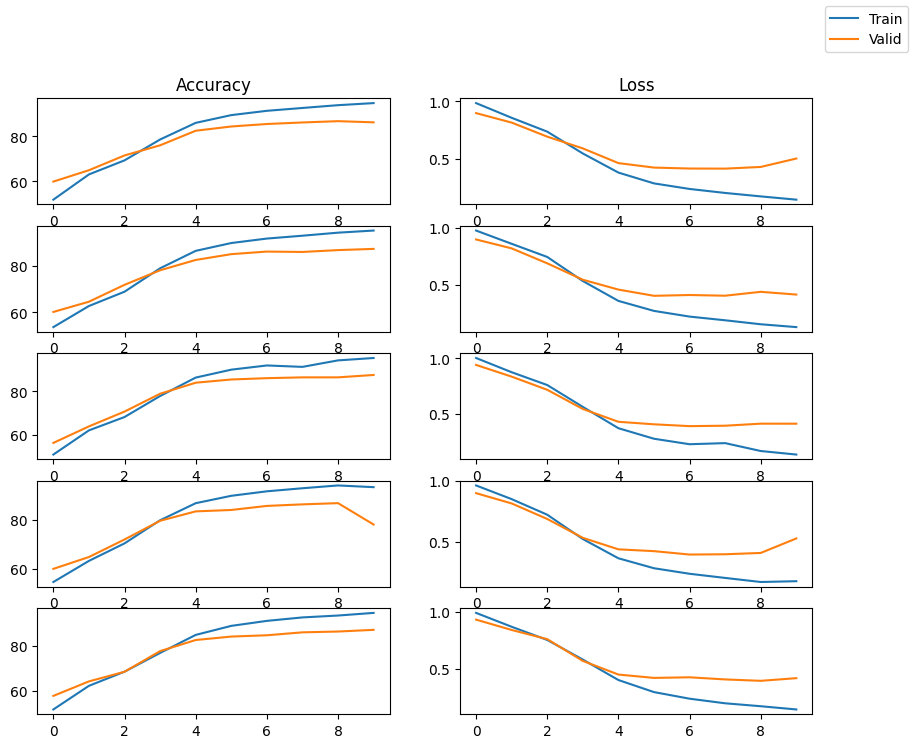

In [74]:
#Visualizing model performance across 10 learnings of 10 epochs
fig, axs = plt.subplots(5,2)
for i, b in enumerate(zip(train_accs,train_loss,valid_accs,valid_loss)):
    axs[i,0].plot(b[0],label = 'Train')
    axs[i,0].plot(b[2],label = 'Valid')
    axs[i,1].plot(b[1],label = 'Train')
    axs[i,1].plot(b[3],label = 'Valid')
    axs[0,1].set_title('Loss')
    axs[0,0].set_title('Accuracy')
fig.legend(['Train','Valid'])
fig.set_size_inches(10,8)
print(f"Max final accuracy on validation: {max([x[9] for x in valid_accs])}")
print(f"Avg final accuracy on validation: {np.mean([x[9] for x in valid_accs])}")
print(f'Minimum difference in final accuracy between training and validation for models that performed better than 80% accuracy on both: {min([x[9] - y[9] for x in train_accs if x[9]>80 for y in valid_accs if y[9]>80])}')

Model performs decent on validation set. Considering rising loss function on validation dataset form 8th epoch, it can be concluded, that model should not be trained longer than 8 epochs.